Episode 1/500, Reward: -2336.88, Epsilon: 1.000, Steps: 14, Avg Q-value: 0.79
Episode 2/500, Reward: -2482.68, Epsilon: 1.000, Steps: 15, Avg Q-value: 0.79
Episode 3/500, Reward: -2468.25, Epsilon: 1.000, Steps: 14, Avg Q-value: 0.79
Episode 4/500, Reward: -2624.18, Epsilon: 1.000, Steps: 14, Avg Q-value: 0.79
Episode 5/500, Reward: -3397.90, Epsilon: 0.992, Steps: 14, Avg Q-value: 2.35
Episode 6/500, Reward: -2643.80, Epsilon: 0.977, Steps: 15, Avg Q-value: 30.02
Episode 7/500, Reward: -2433.29, Epsilon: 0.964, Steps: 14, Avg Q-value: 99.85
Episode 8/500, Reward: -2454.15, Epsilon: 0.950, Steps: 14, Avg Q-value: 101.88
Episode 9/500, Reward: -3063.00, Epsilon: 0.937, Steps: 14, Avg Q-value: 108.82
Episode 10/500, Reward: -2717.03, Epsilon: 0.924, Steps: 14, Avg Q-value: 107.33
Episode 11/500, Reward: -2422.31, Epsilon: 0.911, Steps: 14, Avg Q-value: 101.02
Episode 12/500, Reward: -2312.61, Epsilon: 0.898, Steps: 14, Avg Q-value: 99.48
Episode 13/500, Reward: -2665.54, Epsilon: 0.886, 

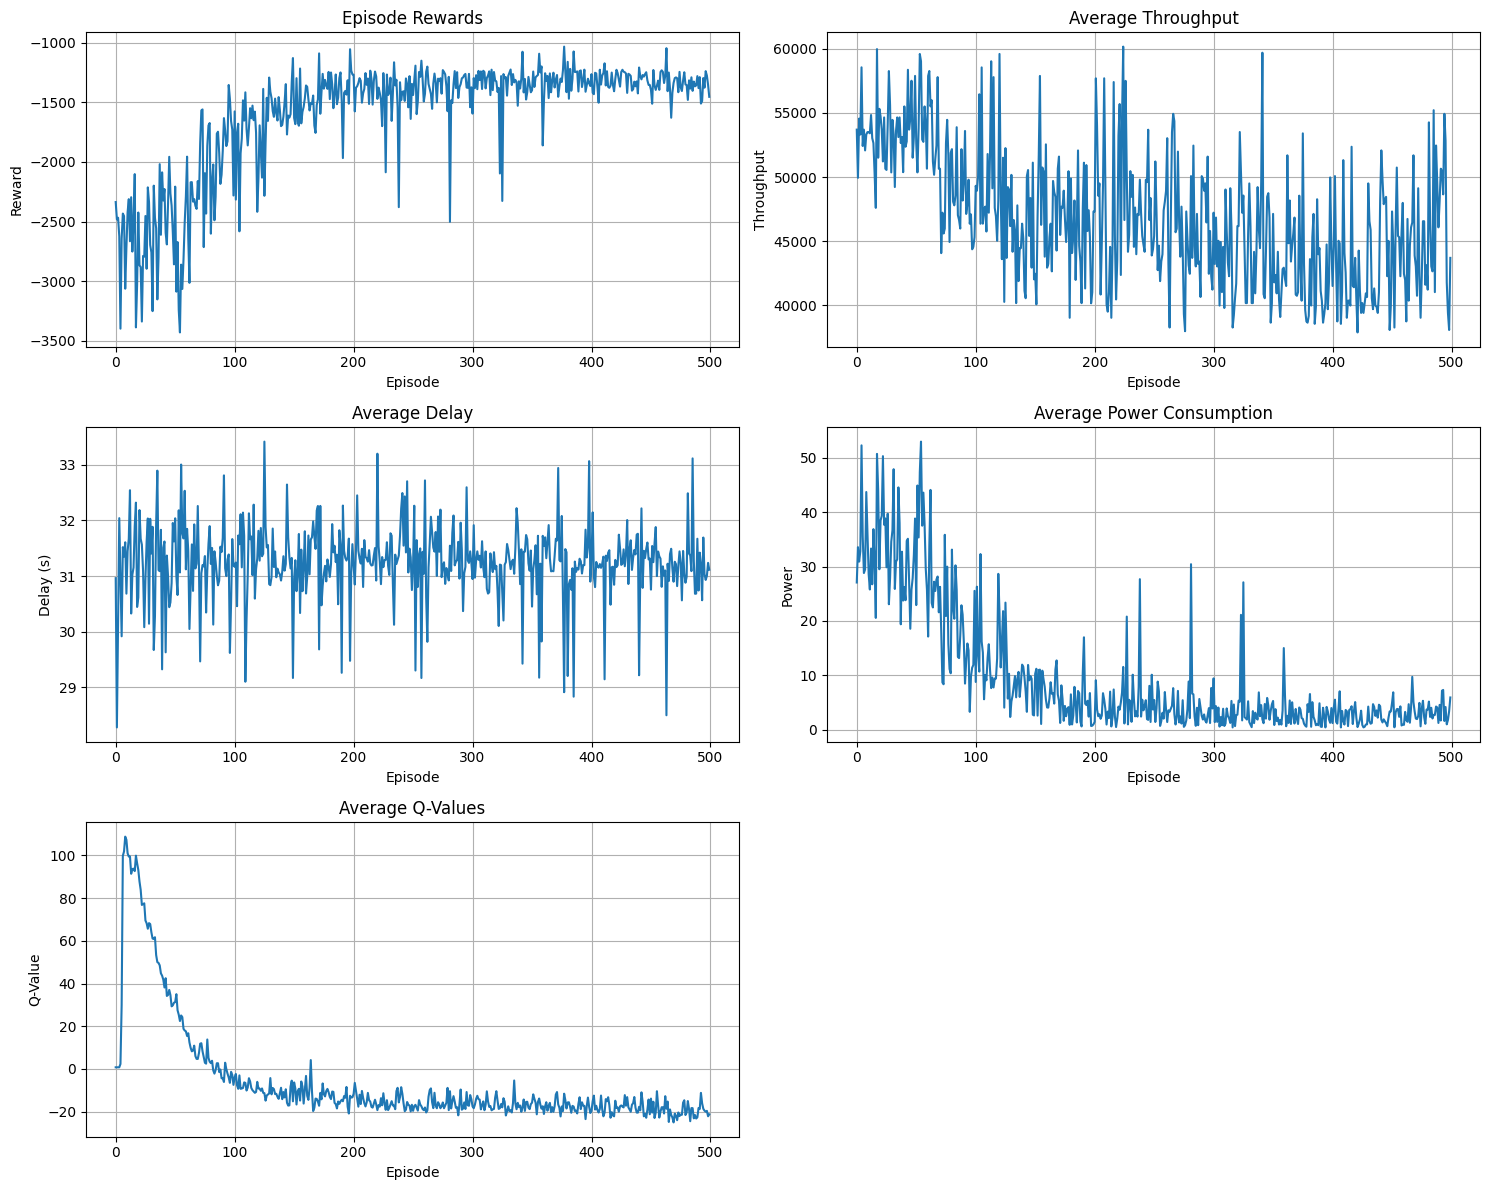

In [2]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

class UAVEnv(object):
    def __init__(self, num_uavs=3):
        self.num_uavs = num_uavs
        self.height = self.ground_length = self.ground_width = 100
        self.sum_task_size = 100 * 1048576.0  # Use float
        self.max_task_size = float(self.sum_task_size)  # Define max_task_size first
        self.loc_uav = np.array([[0, 0] for _ in range(num_uavs)], dtype=float)
        self.bandwidth_nums = 1
        self.B = self.bandwidth_nums * 10 ** 8
        self.p_noisy_los = 10 ** (-13)
        self.p_noisy_nlos = 10 ** (-8)
        self.noise_power_squared = 10**-10
        self.flight_speed = 50.
        self.f_ue = 4e4
        self.f_uav = 1.2e5
        self.r = 10 ** (-17)
        self.s = 1000
        self.p_uplink = 0.1
        self.alpha0 = -30
        self.T = 320
        self.t_fly = 1
        self.t_com = 7
        self.delta_t = self.t_fly + self.t_com
        self.slot_num = int(self.T / self.delta_t)
        self.m_uav = 9.65
        self.e_battery_uav = 500000.0
        self.M = 100
        self.block_flag_list = np.random.uniform(0, 0.3, self.M).astype(float)
        self.loc_ue_list = np.random.randint(0, 30, size=[self.M, 2]).astype(float)
        for i in range(self.M//4):
            self.loc_ue_list[i] = [np.random.randint(90,100), np.random.randint(90,100)]
        self.task_list = np.random.randint(1*10**5, 2*10**5, self.M).astype(float)
        self.state_dim = 1 + (num_uavs * 2) + 1 + (self.M * 2) + self.M + self.M
        self.action_space = 4 * 8 * 4 * 4
        self.start_state = self._get_obs()  # Now safe to call after max_task_size is defined
        self.state = self.start_state

    def step(self, actions):
        is_terminal = False
        rewards = np.zeros(self.num_uavs)
        step_redos = np.zeros(self.num_uavs, dtype=bool)
        offloading_ratios = np.zeros(self.num_uavs)
        throughputs = np.zeros(self.num_uavs)
        Time_ = np.zeros(self.num_uavs)
        power_ = np.zeros(self.num_uavs)

        for i in range(self.num_uavs):
            action_idx = actions[i]
            ue_idx = action_idx // (8 * 4 * 4) % 4
            dir_idx = (action_idx // (4 * 4)) % 8
            off_idx = (action_idx // 4) % 4
            dist_idx = action_idx % 4
            
            ue_id = min(ue_idx * (self.M // 4), self.M - 1)
            theta = dir_idx * (2 * np.pi / 8)
            offloading_ratio = off_idx * 0.25
            dis_fly = dist_idx * self.flight_speed * self.t_fly / 3
            
            offloading_ratios[i] = offloading_ratio
            task_size = self.task_list[ue_id]
            block_flag = self.block_flag_list[ue_id]
            
            e_fly = (dis_fly / self.t_fly) ** 2 * self.m_uav * self.t_fly * 0.05
            dx_uav = dis_fly * math.cos(theta)
            dy_uav = dis_fly * math.sin(theta)
            
            loc_uav_after_fly_x = np.clip(self.loc_uav[i][0] + dx_uav, 0, self.ground_width)
            loc_uav_after_fly_y = np.clip(self.loc_uav[i][1] + dy_uav, 0, self.ground_length)
            
            t_server = task_size * offloading_ratio / self.f_uav
            t_ue = task_size * (1 - offloading_ratio) / self.f_ue
            energy_server = self.r * self.f_uav ** 3 * t_server * 10
            energy_local = self.r * self.f_ue ** 3 * t_ue * 10
            
            if self.sum_task_size == 0:
                is_terminal = True
                rewards[i] = 100
            elif self.sum_task_size - task_size < 0:
                self.task_list = np.ones(self.M) * self.sum_task_size
                rewards[i] = 0
                step_redos[i] = True
            elif self.e_battery_uav < e_fly or self.e_battery_uav - e_fly < energy_server:
                rewards[i] = -10
            else:
                dx = self.loc_ue_list[ue_id][0] - loc_uav_after_fly_x
                dy = self.loc_ue_list[ue_id][1] - loc_uav_after_fly_y
                dh = self.height
                dist = np.sqrt(dx ** 2 + dy ** 2 + dh ** 2)
                x_rand = np.random.randn()
                h_val = 1 / (1 + (dist / 100)**2)**2 * (x_rand**2 + 1)
                p_tran = self.p_uplink * h_val
                alpha = self.alpha0 / (1 + self.height / (dist + 1e-6))**2
                noise_term = self.p_noisy_los * block_flag + self.p_noisy_nlos * (1 - block_flag)
                sinr = np.clip(p_tran * alpha / noise_term, 1e-10, None)
                
                local_execution_delay, transmission_delay, server_execution_delay = self.com_delay(
                    self.loc_ue_list[ue_id], np.array([loc_uav_after_fly_x, loc_uav_after_fly_y]),
                    offloading_ratio, task_size, block_flag)
                
                throughputs[i] = self.throughput(self.loc_ue_list[ue_id],
                                              np.array([loc_uav_after_fly_x, loc_uav_after_fly_y]),
                                              offloading_ratio, task_size, block_flag)
                
                e_fly = e_fly / 10 if offloading_ratio > 0 else 0
                energy = e_fly + energy_server + energy_local
                delay = (local_execution_delay * (1 - offloading_ratio) +
                        server_execution_delay * offloading_ratio + transmission_delay * offloading_ratio)
                
                power_[i] = energy
                Time_[i] = delay
                rewards[i] = -(energy + delay) 
                self.e_battery_uav -= energy
                self.sum_task_size -= task_size
                self.loc_uav[i] = [loc_uav_after_fly_x, loc_uav_after_fly_y]
        
        self.update_ue_locations()
        self.reset_step()
        return (self._get_obs(), rewards, is_terminal, step_redos, offloading_ratios, throughputs, Time_, power_)

    def update_ue_locations(self):
        for j in range(self.M):
            tmp = np.random.rand()
            if tmp <= 0.6:
                pass
            elif 0.6 < tmp <= 0.7:
                self.loc_ue_list[j] += [0, 1]
            elif 0.7 < tmp <= 0.8:
                self.loc_ue_list[j] += [1, 0]
            elif 0.8 < tmp <= 0.9:
                self.loc_ue_list[j] += [0, -1]
            else:
                self.loc_ue_list[j] += [-1, 0]
            self.loc_ue_list[j] = np.clip(self.loc_ue_list[j], 0, 100)

    def reset(self):
        self.sum_task_size = 100 * 1048576.0
        self.e_battery_uav = 500000.0
        self.loc_uav = np.array([[0, 0] for _ in range(self.num_uavs)], dtype=float)
        self.task_list = np.random.randint(1*10**5, 2*10**5, self.M).astype(float)
        self.block_flag_list = np.random.randint(0, 2, self.M).astype(float)
        return self._get_obs()

    def _get_obs(self):
        state = np.array([self.e_battery_uav], dtype=float)
        state = np.append(state, self.loc_uav.flatten())
        state = np.append(state, self.sum_task_size)
        state = np.append(state, self.loc_ue_list.flatten())
        state = np.append(state, self.task_list)
        state = np.append(state, self.block_flag_list)
        # Normalize state
        state[0] /= 500000  # Battery
        state[1:1+self.num_uavs*2] /= 100  # UAV locations
        state[1+self.num_uavs*2] /= self.max_task_size  # Total task size
        state[2+self.num_uavs*2:2+self.num_uavs*2+self.M*2] /= 100  # UE locations
        state[2+self.num_uavs*2+self.M*2:2+self.num_uavs*2+self.M*3] /= 2e5  # Task sizes
        return state

    def reset_step(self):
        self.task_list = np.random.randint(2621440, 3145729, self.M).astype(float)
        self.block_flag_list = np.random.randint(0, 2, self.M).astype(float)

    def com_delay(self, loc_ue, loc_uav, offloading_ratio, task_size, block_flag):
        dx = loc_uav[0] - loc_ue[0]
        dy = loc_uav[1] - loc_ue[1]
        dh = self.height
        dist = np.sqrt(dx**2 + dy**2 + dh**2)
        fading_factor = 1
        channel_gain = (10**-5)/dist if dist != 0 else 100
        snr = float((self.p_uplink*channel_gain*fading_factor)/(self.noise_power_squared+self.p_noisy_nlos))
        transmission_rate = float((self.B*math.log2(1+snr)))
        
        transmission_delay = task_size/transmission_rate if transmission_rate > 0 else float('inf')
        transmission_delay=transmission_delay+block_flag*transmission_delay
        local_execution_delay = task_size/self.f_ue
        server_execution_delay = task_size/self.f_uav
        
        return local_execution_delay/2, transmission_delay*500, server_execution_delay/2

    def throughput(self, loc_ue, loc_uav, offloading_ratio, task_size, block_flag):
        local_execution_delay, transmission_delay, server_execution_delay = self.com_delay(
            loc_ue, loc_uav, offloading_ratio, task_size, block_flag)
        delay = (local_execution_delay*(1-offloading_ratio)*2 + 
                (transmission_delay*offloading_ratio)/500 + 
                server_execution_delay*offloading_ratio*2)
        return task_size/delay if delay > 0 else 0

class DQN(nn.Module):
    def __init__(self, state_dim, action_space):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_space)
        )

    def forward(self, state):
        return self.network(state)

class DQNAgent:
    def __init__(self, state_dim, action_space):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = DQN(state_dim, action_space).to(self.device)
        self.target_network = DQN(state_dim, action_space).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0005)
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.action_space = action_space
        self.update_target_network(tau=1.0)
        self.update_frequency = 100
        self.steps = 0

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_space)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state)
        return q_values.max(1)[1].item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_network(self, tau=0.005):
        for target_param, param in zip(self.target_network.parameters(), 
                                     self.q_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        self.steps += 1
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_actions = self.q_network(next_states).max(1)[1].unsqueeze(1)
        next_q_values = self.target_network(next_states).gather(1, next_actions).squeeze()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        if self.steps % self.update_frequency == 0:
            self.update_target_network()
        
        return loss.item()

# Training Loop
env = UAVEnv(num_uavs=3)
num_uavs = env.num_uavs
state_dim = env.state_dim
action_space = env.action_space

agents = [DQNAgent(state_dim, action_space) for _ in range(num_uavs)]

episode_rewards = []
episode_throughputs = []
episode_delays = []
episode_powers = []
avg_q_values = []

num_episodes = 500
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    throughputs = []
    delays = []
    powers = []
    q_values_episode = []
    
    step_count = 0
    while True:
        actions = [agent.choose_action(state) for agent in agents]
        next_state, rewards, is_terminal, step_redos, offloading_ratios, throughputs_step, Time_, power_ = env.step(actions)
        
        for i in range(num_uavs):
            agents[i].store_experience(state, actions[i], rewards[i], next_state, is_terminal)
            loss = agents[i].train()
            with torch.no_grad():
                q_val = agents[i].q_network(torch.FloatTensor(state).unsqueeze(0).to(agents[i].device)).max().item()
                q_values_episode.append(q_val)
        
        total_reward += np.sum(rewards)
        throughputs.append(np.mean(throughputs_step))
        delays.append(np.mean(Time_))
        powers.append(np.mean(power_))
        
        state = next_state
        
        step_count += 1
        if is_terminal or step_count > 1000:
            break
    
    episode_rewards.append(total_reward)
    episode_throughputs.append(np.mean(throughputs))
    episode_delays.append(np.mean(delays))
    episode_powers.append(np.mean(powers))
    avg_q_values.append(np.mean(q_values_episode))
    
    print(f"Episode {episode+1}/{num_episodes}, Reward: {total_reward:.2f}, "
          f"Epsilon: {agents[0].epsilon:.3f}, Steps: {step_count}, "
          f"Avg Q-value: {avg_q_values[-1]:.2f}")

# Plotting
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(episode_throughputs)
plt.title('Average Throughput')
plt.xlabel('Episode')
plt.ylabel('Throughput')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(episode_delays)
plt.title('Average Delay')
plt.xlabel('Episode')
plt.ylabel('Delay (s)')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(episode_powers)
plt.title('Average Power Consumption')
plt.xlabel('Episode')
plt.ylabel('Power')
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(avg_q_values)
plt.title('Average Q-Values')
plt.xlabel('Episode')
plt.ylabel('Q-Value')
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
import pickle
# Save lists to a file
lists_to_save = {
    'episode_rewards': episode_rewards,
    'episode_throughputs': episode_throughputs,
    'episode_Time_': episode_delays,
    'episode_power_': episode_powers
}

with open('saved_lists_DQN_new.pkl', 'wb') as file:
    pickle.dump(lists_to_save, file)

print('file created successfully')

file created successfully
